In [1]:
import matplotlib.pyplot as plt
from autoencoders import SSIMLoss
import numpy as np
from PIL import Image
import torch
import numpy as np
from utils.datasets import get_datasets
import time

# Setting
Image.MAX_IMAGE_PIXELS = None
loss_function_ssim = SSIMLoss().cuda()
loss_function_mse = torch.nn.MSELoss().cuda()
loss_function_mae = torch.nn.L1Loss().cuda()
loss_function_bce = torch.nn.BCELoss().cuda()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("running on: {}".format(device))

# Creating dataset
test_paths = [ 'Gleason/Data_0_SUS/20180911_SUS/test_299',
               'Gleason/Data_0_SUS/20180911_Helsingborg/test_299',
               'Gleason/Data_0_SUS/20180911_Linkoping/test_299',
               'Gleason/Data_0_SUS/20180911_Rotterdam/test_299'
             ]

/home/gu3106ju-s/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


running on: cuda:0


In [2]:
test_dataset, _ = get_datasets(test_paths, device, val_split=0, binary=True)
n_test = len(test_dataset)
loader_test = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [3]:
classifier = torch.load('classifier.pht')
classifier.eval()

autoencoder = torch.load('autoencoder.pht')
autoencoder.eval()
n_auto = len(autoencoder.encoders)

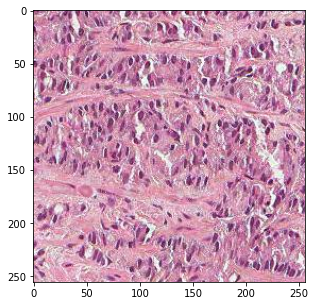

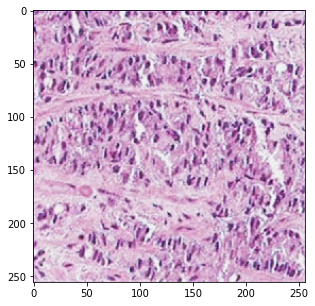

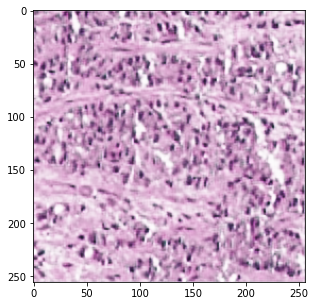

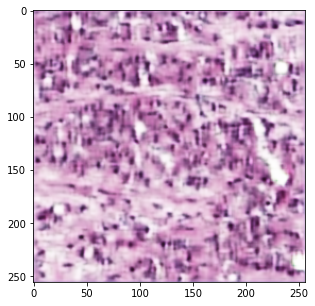

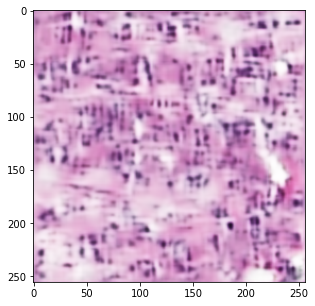

In [5]:
image_batch, target_batch = next(iter(loader_test)) 

for dim in range(-1, n_auto):
      fig, ax = plt.subplots(figsize=(5,5))
      image = image_batch[0].reshape(1,3,256,256)    
      rec_item = autoencoder(image,dim)
      rec_image = rec_item[0,:,:,:].movedim(0,-1).cpu().detach().numpy()
      ax.imshow(rec_image)
      plt.show() 


In [5]:
autoencoder_losses = []
classifier_losses = []
performance_metrics = []
autoencoder_losses_ssim = []

with torch.no_grad():
    # for dim in range(-1, n_auto):
    for dim in [-1,0,1,2,3]:
        print(f'dim: {dim}')
        
        total_loss_autoencoder = 0
        total_loss_classifier = 0
        total_images = 0
        total_correct = 0
        total_ssim=0
        
        true_negative=0
        true_positive=0
        false_negative=0
        false_positive=0
        
        i=0
        t1 = time.time()
        for image, target in loader_test: 
            
            # input and target
            image = image.to(device)
            target = target.to(device).reshape(-1,1).float()

            # reconstruction + prediction
            reconstructed = autoencoder(image, dim)
            y_pred = classifier(reconstructed)

            # losses for reconstruction and prediction
            loss_ssim = loss_function_ssim(reconstructed, image)
            loss_mse = loss_function_mse(reconstructed, image)
            loss_mae = loss_function_mae(reconstructed, image)
            loss_autoencoder = 0.5*loss_ssim + 0.5*loss_mse + 0.5*loss_mae
            loss_classifier = loss_function_bce(y_pred, target)

            # calculating total losses
            total_loss_autoencoder += image.shape[0]*loss_autoencoder.item()
            total_loss_classifier += image.shape[0]*loss_classifier.item()
            total_images += image.shape[0]
            true_negative += ((target == 0) & ((y_pred>0.5)==0)).float().sum()
            true_positive += ((target == 1) & ((y_pred>0.5)==1)).float().sum()
            false_negative += ((target == 1) & ((y_pred>0.5)==0)).float().sum()
            false_positive += ((target == 0) & ((y_pred>0.5)==1)).float().sum()
            total_ssim += image.shape[0]*(1 - loss_ssim.item())

            if i%10==0:
                t2 = time.time()
                print(f'''
                    -> [{total_images}/{n_test}] | 
                        loss_classifier: {total_loss_classifier/total_images} | 
                        loss_autoencoder: {total_loss_autoencoder/total_images} | 
                        accuracy: {(true_positive + true_negative)/total_images} |
                        recall: {true_positive/(true_positive+false_negative)} |
                        precision: {true_positive/(true_positive+false_positive)} |
                        time: {t2-t1}
                    ''')
                t1 = time.time()
            i+=1
        autoencoder_losses.append(total_loss_autoencoder/total_images)
        classifier_losses.append(total_loss_classifier/total_images)
        performance_metrics.append({'FP': false_positive, 'FN': false_negative, 'TP': true_positive, 'TN': true_negative})
        autoencoder_losses_ssim.append(total_ssim/total_images)

dim: -1

                    -> [32/12772] | 
                        loss_classifier: 0.35763660073280334 | 
                        loss_autoencoder: 0.0 | 
                        accuracy: 0.84375 |
                        recall: 0.875 |
                        precision: 0.8235294222831726 |
                        time: 3.4435460567474365
                    

                    -> [352/12772] | 
                        loss_classifier: 0.3256754997101697 | 
                        loss_autoencoder: 0.0 | 
                        accuracy: 0.8835227489471436 |
                        recall: 0.9273743033409119 |
                        precision: 0.8556700944900513 |
                        time: 6.658791780471802
                    

                    -> [672/12772] | 
                        loss_classifier: 0.2995748519897461 | 
                        loss_autoencoder: 0.0 | 
                        accuracy: 0.8958333730697632 |
                        recall: 0.9442815

In [ ]:
sizes = [np.prod(autoencoder.encode(image,i).shape[1:]) for i in range(-1,4)]
accuracies = [(dim['TP'].item() + dim['TN'].item())/n_test for dim in performance_metrics]
sensitivity = [(dim['TP'].item())/(dim['TP'].item() + dim['FN'].item()) for dim in performance_metrics]
specificity = [(dim['TN'].item())/(dim['TN'].item() + dim['FP'].item()) for dim in performance_metrics]
precision = [(dim['TP'].item())/(dim['TP'].item() + dim['FP'].item()) for dim in performance_metrics]

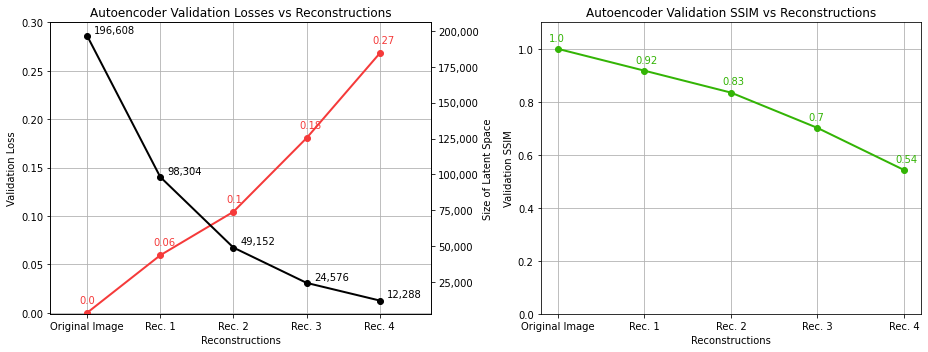

In [43]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))
x = range(len(autoencoder_losses))
ax[0].set_title('Autoencoder Validation Losses vs Reconstructions')
ax[0].plot(x, autoencoder_losses, color='#f53a3aff', marker='o', linewidth=2, markersize=6)
for i,j in zip(x,autoencoder_losses):
    ax[0].annotate(str(round(j,2)),xy=(i-0.1,j+0.01),c='#f53a3aff')

ax2 = ax[0].twinx()
ax2.plot(x, sizes, color='black', linewidth=2, marker='o', markersize=6)
for i,j in zip(x,sizes):
    ax2.annotate(str(format(round(j,2), ',')),xy=(i+0.1,j+2000),c='black')
ax2.set_ylabel('Size of Latent Space')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax[0].set_xlim(-0.5,4.7)
ax[0].set_xticks((0,1,2,3,4))
ax[0].set_xticklabels(('Original Image','Rec. 1','Rec. 2','Rec. 3','Rec. 4'))
ax[0].set_ylim(-0.001,0.3)
ax[0].set_ylabel('Validation Loss')
ax[0].set_xlabel('Reconstructions')
ax[0].grid()

ax[1].set_title('Autoencoder Validation SSIM vs Reconstructions')
ax[1].plot(x, autoencoder_losses_ssim, color='#33b405ff', marker='o', linewidth=2, markersize=6)
for i,j in zip(x,autoencoder_losses_ssim):
    ax[1].annotate(str(round(j,2)),xy=(i-0.1,j+0.03),c='#33b405ff')
ax[1].set_xticks((0,1,2,3,4))
ax[1].set_xticklabels(('Original Image','Rec. 1','Rec. 2','Rec. 3','Rec. 4'))
ax[1].set_ylabel('Validation SSIM')
ax[1].set_xlabel('Reconstructions')
ax[1].set_ylim(0,1.1)
ax[1].set_yticks(np.arange(0,1.1,0.2))
ax[1].grid()

plt.tight_layout()

plt.show()

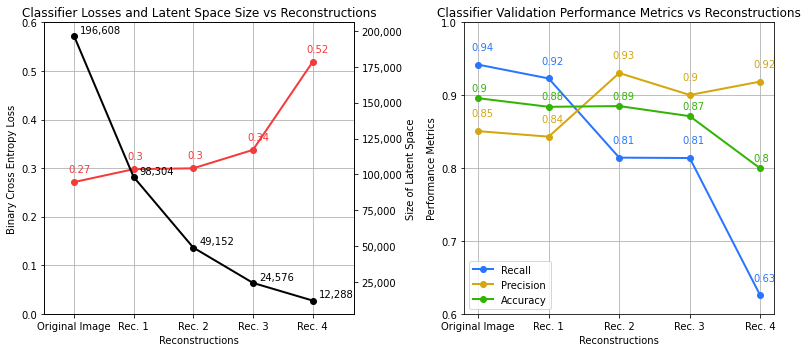

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(11,5))

x = range(len(autoencoder_losses))

ax[0].set_title('Classifier Losses and Latent Space Size vs Reconstructions')
ax[0].plot(x, classifier_losses, color='#f53a3aff', linewidth=2, marker='o', markersize=6)
for i,j in zip(x,classifier_losses):
    ax[0].annotate(str(round(j,2)),xy=(i-0.1,j+0.02),c='#f53a3aff')
    
ax2 = ax[0].twinx()
ax2.plot(x, sizes, color='black', linewidth=2, marker='o', markersize=6)
for i,j in zip(x,sizes):
    ax2.annotate(str(format(round(j,2), ',')),xy=(i+0.1,j+2000),c='black')
    
ax[0].set_xlim(-0.5,4.7)
ax[0].set_ylim(0.25,0.6)
ax[0].set_xticks((0,1,2,3,4))
ax[0].set_xticklabels(('Original Image','Rec. 1','Rec. 2','Rec. 3','Rec. 4'))
ax[0].set_ylabel('Binary Cross Entropy Loss')
ax2.set_ylabel('Size of Latent Space')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel('Reconstructions')
ax[0].set_yticks(np.arange(0,0.7,0.1))
ax[0].grid()

ax[1].set_title('Classifier Validation Performance Metrics vs Reconstructions')
ax[1].plot(x, sensitivity, color='#2876ffff', linewidth=2, marker='o', markersize=6, label='Recall')
for i,j in zip(x,sensitivity):
    ax[1].annotate(str(round(j,2)),xy=(i-0.1,j+0.02),c='#2876ffff')
    
ax[1].plot(x, precision, color='#d5a60dff', linewidth=2, marker='o', markersize=6, label='Precision')
for i,j in zip(x,precision):
    ax[1].annotate(str(round(j,2)),xy=(i-0.1,j+0.02),c='#d5a60dff')

ax[1].plot(x, accuracies,  color='#33b405ff', linewidth=2, marker='o', markersize=6, label='Accuracy')
for i,j in zip(x,accuracies):
    ax[1].annotate(str(round(j,2)),xy=(i-0.1,j+0.01),c='#33b405ff')
    
ax[1].set_xticks((0,1,2,3,4))
ax[1].set_xticklabels(('Original Image','Rec. 1','Rec. 2','Rec. 3','Rec. 4'))
ax[1].set_ylabel('Performance Metrics')
ax[1].set_xlabel('Reconstructions')
ax[1].set_yticks(np.arange(0.6,1.001,0.1))
ax[1].legend(loc='lower left')
ax[1].grid()

plt.tight_layout()
plt.show()